In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)


2.11.0


Gather Data

In [36]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

Copy of raw dataset to be set as the actual dataset for the notebook

In [37]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


Dropping the rows that contain 0 values to keep the notebook simple

In [38]:
print("=====Before removing=====")
print(dataset.isna().sum())
dataset = dataset.dropna()
print("=====After removing=====")
print(dataset.isna().sum())

=====Before removing=====
MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64
=====After removing=====
MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


One Hot encode using map function of the pandas dataframe

In [39]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


Splitting dataset into training and testing sets

In [40]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [41]:
train_dataset.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
count,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000
mean,23.310510,5.477707,195.318471,104.869427,2990.251592,15.559236,75.898089,0.178344,0.197452,0.624204
std,7.728652,1.699788,104.331589,38.096214,843.898596,2.789230,3.675642,0.383413,0.398712,0.485101
min,10.000000,3.000000,68.000000,46.000000,1649.000000,8.000000,70.000000,0.000000,0.000000,0.000000
25%,17.000000,4.000000,105.500000,76.250000,2256.500000,13.800000,73.000000,0.000000,0.000000,0.000000
50%,22.000000,4.000000,151.000000,94.500000,2822.500000,15.500000,76.000000,0.000000,0.000000,1.000000
75%,28.950000,8.000000,265.750000,128.000000,3608.000000,17.200000,79.000000,0.000000,0.000000,1.000000
max,46.600000,8.000000,455.000000,225.000000,5140.000000,24.800000,82.000000,1.000000,1.000000,1.000000


Removing the target variable (label) from the other variables (features)

In [42]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

Normalization Part using tensorflow normalization

In [43]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


In [44]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [45]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 9)                19        
 ion)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                640       
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [46]:
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_data = (test_features, test_labels),
    verbose=1, epochs=100)

Epoch 1/100
10/10 [==============================] - 1s 29ms/step - loss: 22.8762 - val_loss: 22.9667
Epoch 2/100
10/10 [==============================] - 0s 6ms/step - loss: 21.7792 - val_loss: 21.7381
Epoch 3/100
10/10 [==============================] - 0s 7ms/step - loss: 20.4273 - val_loss: 20.1485
Epoch 4/100
10/10 [==============================] - 0s 7ms/step - loss: 18.6305 - val_loss: 17.9712
Epoch 5/100
10/10 [==============================] - 0s 7ms/step - loss: 16.2039 - val_loss: 15.3570
Epoch 6/100
10/10 [==============================] - 0s 6ms/step - loss: 13.6887 - val_loss: 12.9089
Epoch 7/100
10/10 [==============================] - 0s 6ms/step - loss: 10.9562 - val_loss: 9.7810
Epoch 8/100
10/10 [==============================] - 0s 7ms/step - loss: 7.6743 - val_loss: 5.9602
Epoch 9/100
10/10 [==============================] - 0s 6ms/step - loss: 5.2228 - val_loss: 4.7276
Epoch 10/100
10/10 [==============================] - 0s 7ms/step - loss: 4.3932 - val_loss: 3.

In [47]:
test_results = {}
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [48]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
dnn_model,1.811029


3/3 [==============================] - 0s 3ms/step


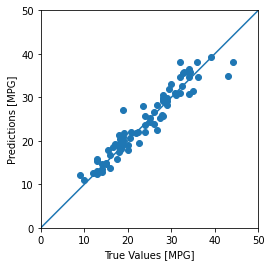

In [49]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [50]:
print(test_predictions)

[14.91  10.961 12.101 25.162 20.124 12.78  13.626 12.451 19.28  31.484
 24.291 26.982 15.292 25.709 12.499 14.741 14.635 13.143 18.658 12.568
 13.717 25.795 20.768 22.006 30.602 23.958 16.821 23.596 17.481 19.05
 28.309 21.319 19.009 21.878 26.702 15.751 19.469 29.104 29.903 17.843
 31.017 29.133 15.928 34.963 34.728 35.569 20.629 21.976 20.5   25.316
 31.003 19.345 31.904 18.592 17.867 18.097 34.733 34.609 21.844 26.013
 38.109 32.708 28.125 27.957 33.177 39.271 36.493 35.758 35.914 30.524
 22.044 22.426 29.633 30.782 38.202 35.551 38.115 29.806]


In [51]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model\assets


INFO:tensorflow:Assets written to: dnn_model\assets
